In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 10.0 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.75
batch_size_value = 64
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
# noise = 'salt&pepper'
noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 1s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:00<00:00, 20991.49it/s]



salt&pepper noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 20942.62it/s]


salt&pepper noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

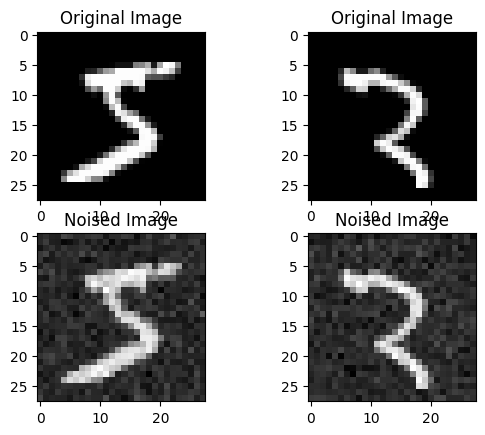

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

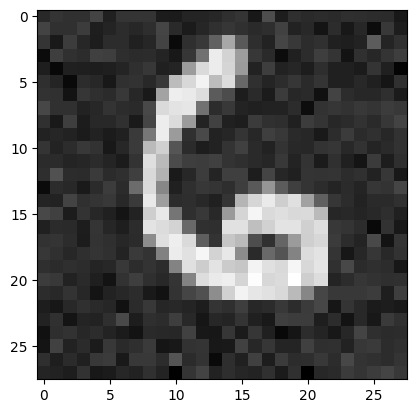

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

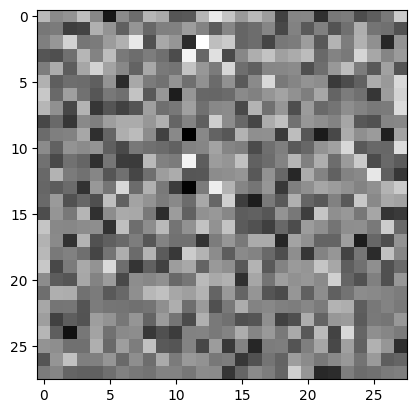

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(957.4922, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

2291.239501953125

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000, -0.0156, -0.0156,  ...,  0.0156,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0156,  0.0000, -0.0156],
        [-0.0156,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000, -0.0156,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0156,  ...,  0.0000,  0.0156,  0.0000],
        [ 0.0000,  0.0000, -0.0156,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


  0 4138.8350 1373.1145


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


  1 2555.4746 1170.8169


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  2 2165.8723 1097.2057


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  3 1983.0649 1059.6658


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  4 1875.5417 1035.0310


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  5 1805.7159 1016.6896


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  6 1761.4009 1000.3308


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


  7 1724.1449 990.2744


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


  8 1700.4669 980.3973


100%|██████████| 157/157 [03:39<00:00,  1.40s/it]


  9 1677.6827 974.1375


100%|██████████| 157/157 [03:40<00:00,  1.40s/it]


 10 1661.2277 967.0051


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 11 1646.4701 960.7842


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 12 1633.0322 956.6280


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 13 1622.1658 950.0675


100%|██████████| 157/157 [03:41<00:00,  1.41s/it]


 14 1610.2112 946.7339


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 15 1599.2427 944.2539


100%|██████████| 157/157 [03:43<00:00,  1.43s/it]


 16 1593.7513 938.9968


100%|██████████| 157/157 [03:39<00:00,  1.40s/it]


 17 1583.3208 936.0822


100%|██████████| 157/157 [03:48<00:00,  1.45s/it]


 18 1576.0896 934.0253


100%|██████████| 157/157 [03:56<00:00,  1.50s/it]


 19 1568.6129 931.6246


100%|██████████| 157/157 [03:48<00:00,  1.46s/it]


 20 1561.3174 928.6949


100%|██████████| 157/157 [03:48<00:00,  1.46s/it]


 21 1554.9240 926.9548


100%|██████████| 157/157 [03:43<00:00,  1.43s/it]


 22 1545.1338 921.4813


100%|██████████| 157/157 [03:42<00:00,  1.42s/it]


 23 1542.1582 922.3868


100%|██████████| 157/157 [03:43<00:00,  1.43s/it]


 24 1536.5385 920.1027


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 25 1531.3602 920.5770


100%|██████████| 157/157 [03:35<00:00,  1.38s/it]


 26 1528.5249 919.8611


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 27 1520.2533 917.8754


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 28 1516.2325 914.4777


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 29 1510.1279 913.0227


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 30 1506.8281 911.8436


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


 31 1501.0665 909.8748


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 32 1496.9949 909.8909


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 33 1493.5983 908.2388


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 34 1490.6019 908.3615


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 35 1485.5149 907.7418


100%|██████████| 157/157 [03:39<00:00,  1.40s/it]


 36 1482.1670 905.5474


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 37 1477.4094 904.4869


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 38 1473.4797 903.4724


100%|██████████| 157/157 [03:31<00:00,  1.34s/it]


 39 1469.0536 900.3922


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


 40 1467.2996 899.4842


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 41 1461.9210 899.2534


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 42 1458.5997 897.5474


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 43 1454.6549 895.6619


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 44 1452.5864 896.1910


100%|██████████| 157/157 [03:30<00:00,  1.34s/it]


 45 1448.7269 894.5350


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 46 1447.4197 895.4425


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 47 1444.2245 895.8767


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 48 1440.2283 892.3385


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 49 1438.2389 891.9542

  2 MSE    Topo  


100%|██████████| 157/157 [03:42<00:00,  1.41s/it]


  0 4178.9814 1383.9531


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  1 2582.9658 1179.9282


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  2 2179.2996 1104.7335


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


  3 1988.8058 1067.3326


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


  4 1870.7181 1040.4045


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


  5 1798.4514 1023.4321


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  6 1749.1777 1011.1754


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


  7 1719.6134 1002.7776


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


  8 1695.8292 991.1783


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


  9 1678.5414 982.2758


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 10 1664.8835 976.1434


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 11 1653.9789 969.6823


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 12 1643.8290 963.7864


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 13 1634.6802 960.0866


100%|██████████| 157/157 [03:35<00:00,  1.38s/it]


 14 1627.3608 957.3849


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 15 1617.6561 952.3636


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 16 1611.2136 948.9361


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 17 1601.0582 946.1326


100%|██████████| 157/157 [03:37<00:00,  1.38s/it]


 18 1594.3748 941.7579


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 19 1587.8096 941.2711


100%|██████████| 157/157 [03:46<00:00,  1.45s/it]


 20 1578.8893 936.4583


100%|██████████| 157/157 [03:46<00:00,  1.44s/it]


 21 1573.5076 932.8380


100%|██████████| 157/157 [03:42<00:00,  1.42s/it]


 22 1569.6039 934.0959


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


 23 1560.4807 929.9574


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 24 1556.0455 927.9924


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 25 1548.7185 925.0342


100%|██████████| 157/157 [03:30<00:00,  1.34s/it]


 26 1543.3531 924.2657


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 27 1536.1816 920.2287


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 28 1531.4801 921.1414


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 29 1524.9049 918.5462


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 30 1519.5518 916.0971


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 31 1513.8987 914.9785


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 32 1508.6801 912.8756


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 33 1505.4034 912.7404


100%|██████████| 157/157 [03:29<00:00,  1.34s/it]


 34 1499.9734 909.7309


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 35 1496.4871 910.2156


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 36 1489.8011 908.4633


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


 37 1484.9745 907.1747


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 38 1483.0887 907.1724


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 39 1478.6479 906.5361


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 40 1474.2583 904.7949


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 41 1468.4861 902.8382


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 42 1464.9215 902.0540


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 43 1461.5460 902.9397


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 44 1460.1100 901.4789


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 45 1456.0360 899.5297


100%|██████████| 157/157 [03:31<00:00,  1.35s/it]


 46 1455.0928 900.1810


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 47 1449.3591 898.6605


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 48 1447.7614 898.0483


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 49 1443.5083 897.3854

  3 MSE    Topo  


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


  0 4089.7834 1382.4077


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


  1 2502.8633 1163.4325


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


  2 2131.2517 1094.8892


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


  3 1958.4861 1055.8730


100%|██████████| 157/157 [03:32<00:00,  1.36s/it]


  4 1854.1107 1030.6696


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


  5 1784.3472 1012.5209


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


  6 1734.9797 999.4355


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


  7 1703.7209 986.9937


100%|██████████| 157/157 [03:45<00:00,  1.43s/it]


  8 1682.1389 977.9904


100%|██████████| 157/157 [03:40<00:00,  1.40s/it]


  9 1665.2357 971.1933


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


 10 1651.5306 963.5775


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 11 1637.7032 957.7946


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 12 1625.5654 954.0977


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 13 1617.2672 949.7048


100%|██████████| 157/157 [03:30<00:00,  1.34s/it]


 14 1605.3236 945.0390


100%|██████████| 157/157 [03:32<00:00,  1.36s/it]


 15 1595.2162 940.6390


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 16 1589.2939 939.2238


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 17 1581.0276 934.9050


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


 18 1575.7482 932.7884


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


 19 1566.6504 929.2933


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 20 1560.6808 928.4938


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 21 1552.2887 925.3911


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


 22 1547.2843 923.1596


100%|██████████| 157/157 [03:29<00:00,  1.34s/it]


 23 1541.4415 923.3798


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 24 1534.8802 919.3442


100%|██████████| 157/157 [03:35<00:00,  1.38s/it]


 25 1530.2072 917.9367


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 26 1523.6567 916.8742


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 27 1517.7083 914.6454


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 28 1513.0692 915.2054


100%|██████████| 157/157 [03:37<00:00,  1.38s/it]


 29 1505.7018 910.7415


100%|██████████| 157/157 [03:34<00:00,  1.37s/it]


 30 1503.2928 911.4041


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 31 1498.2427 909.4601


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 32 1493.3387 907.6516


100%|██████████| 157/157 [03:34<00:00,  1.36s/it]


 33 1487.9677 905.2590


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 34 1484.4517 906.4431


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 35 1480.7538 904.7365


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 36 1476.5012 902.7971


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 37 1471.3934 902.6964


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 38 1471.5259 903.1596


100%|██████████| 157/157 [03:37<00:00,  1.38s/it]


 39 1465.0701 899.6063


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 40 1462.7446 899.4678


100%|██████████| 157/157 [03:43<00:00,  1.42s/it]


 41 1457.8151 897.5900


100%|██████████| 157/157 [03:37<00:00,  1.39s/it]


 42 1453.5764 897.2396


100%|██████████| 157/157 [03:36<00:00,  1.38s/it]


 43 1452.7793 897.1531


100%|██████████| 157/157 [03:35<00:00,  1.37s/it]


 44 1447.6593 896.7819


100%|██████████| 157/157 [03:33<00:00,  1.36s/it]


 45 1447.3478 896.3463


100%|██████████| 157/157 [03:32<00:00,  1.35s/it]


 46 1443.1644 895.1805


100%|██████████| 157/157 [03:38<00:00,  1.39s/it]


 47 1441.5676 895.4559


100%|██████████| 157/157 [03:37<00:00,  1.38s/it]


 48 1437.8884 893.9039


100%|██████████| 157/157 [03:37<00:00,  1.38s/it]

 49 1434.5903 891.7208

CPU times: user 17h 31min 36s, sys: 1min 19s, total: 17h 32min 55s
Wall time: 9h 8s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

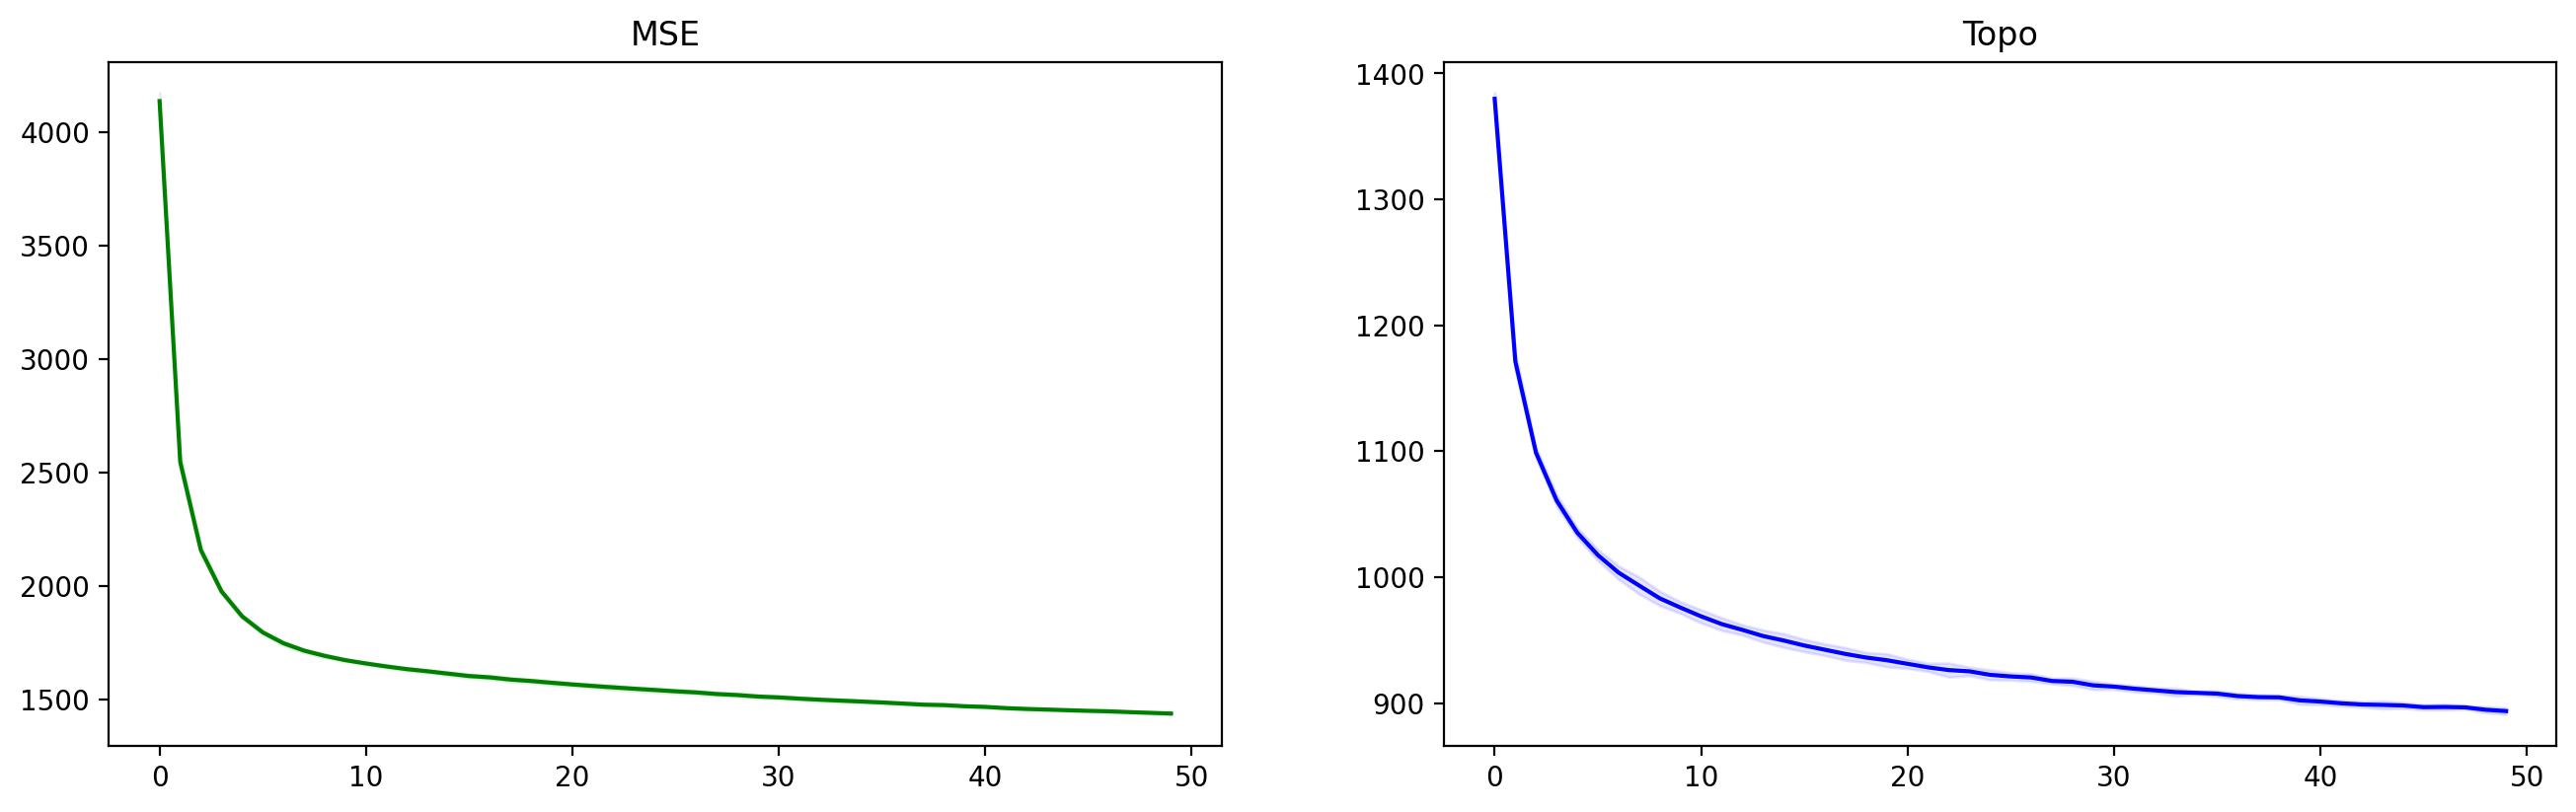

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

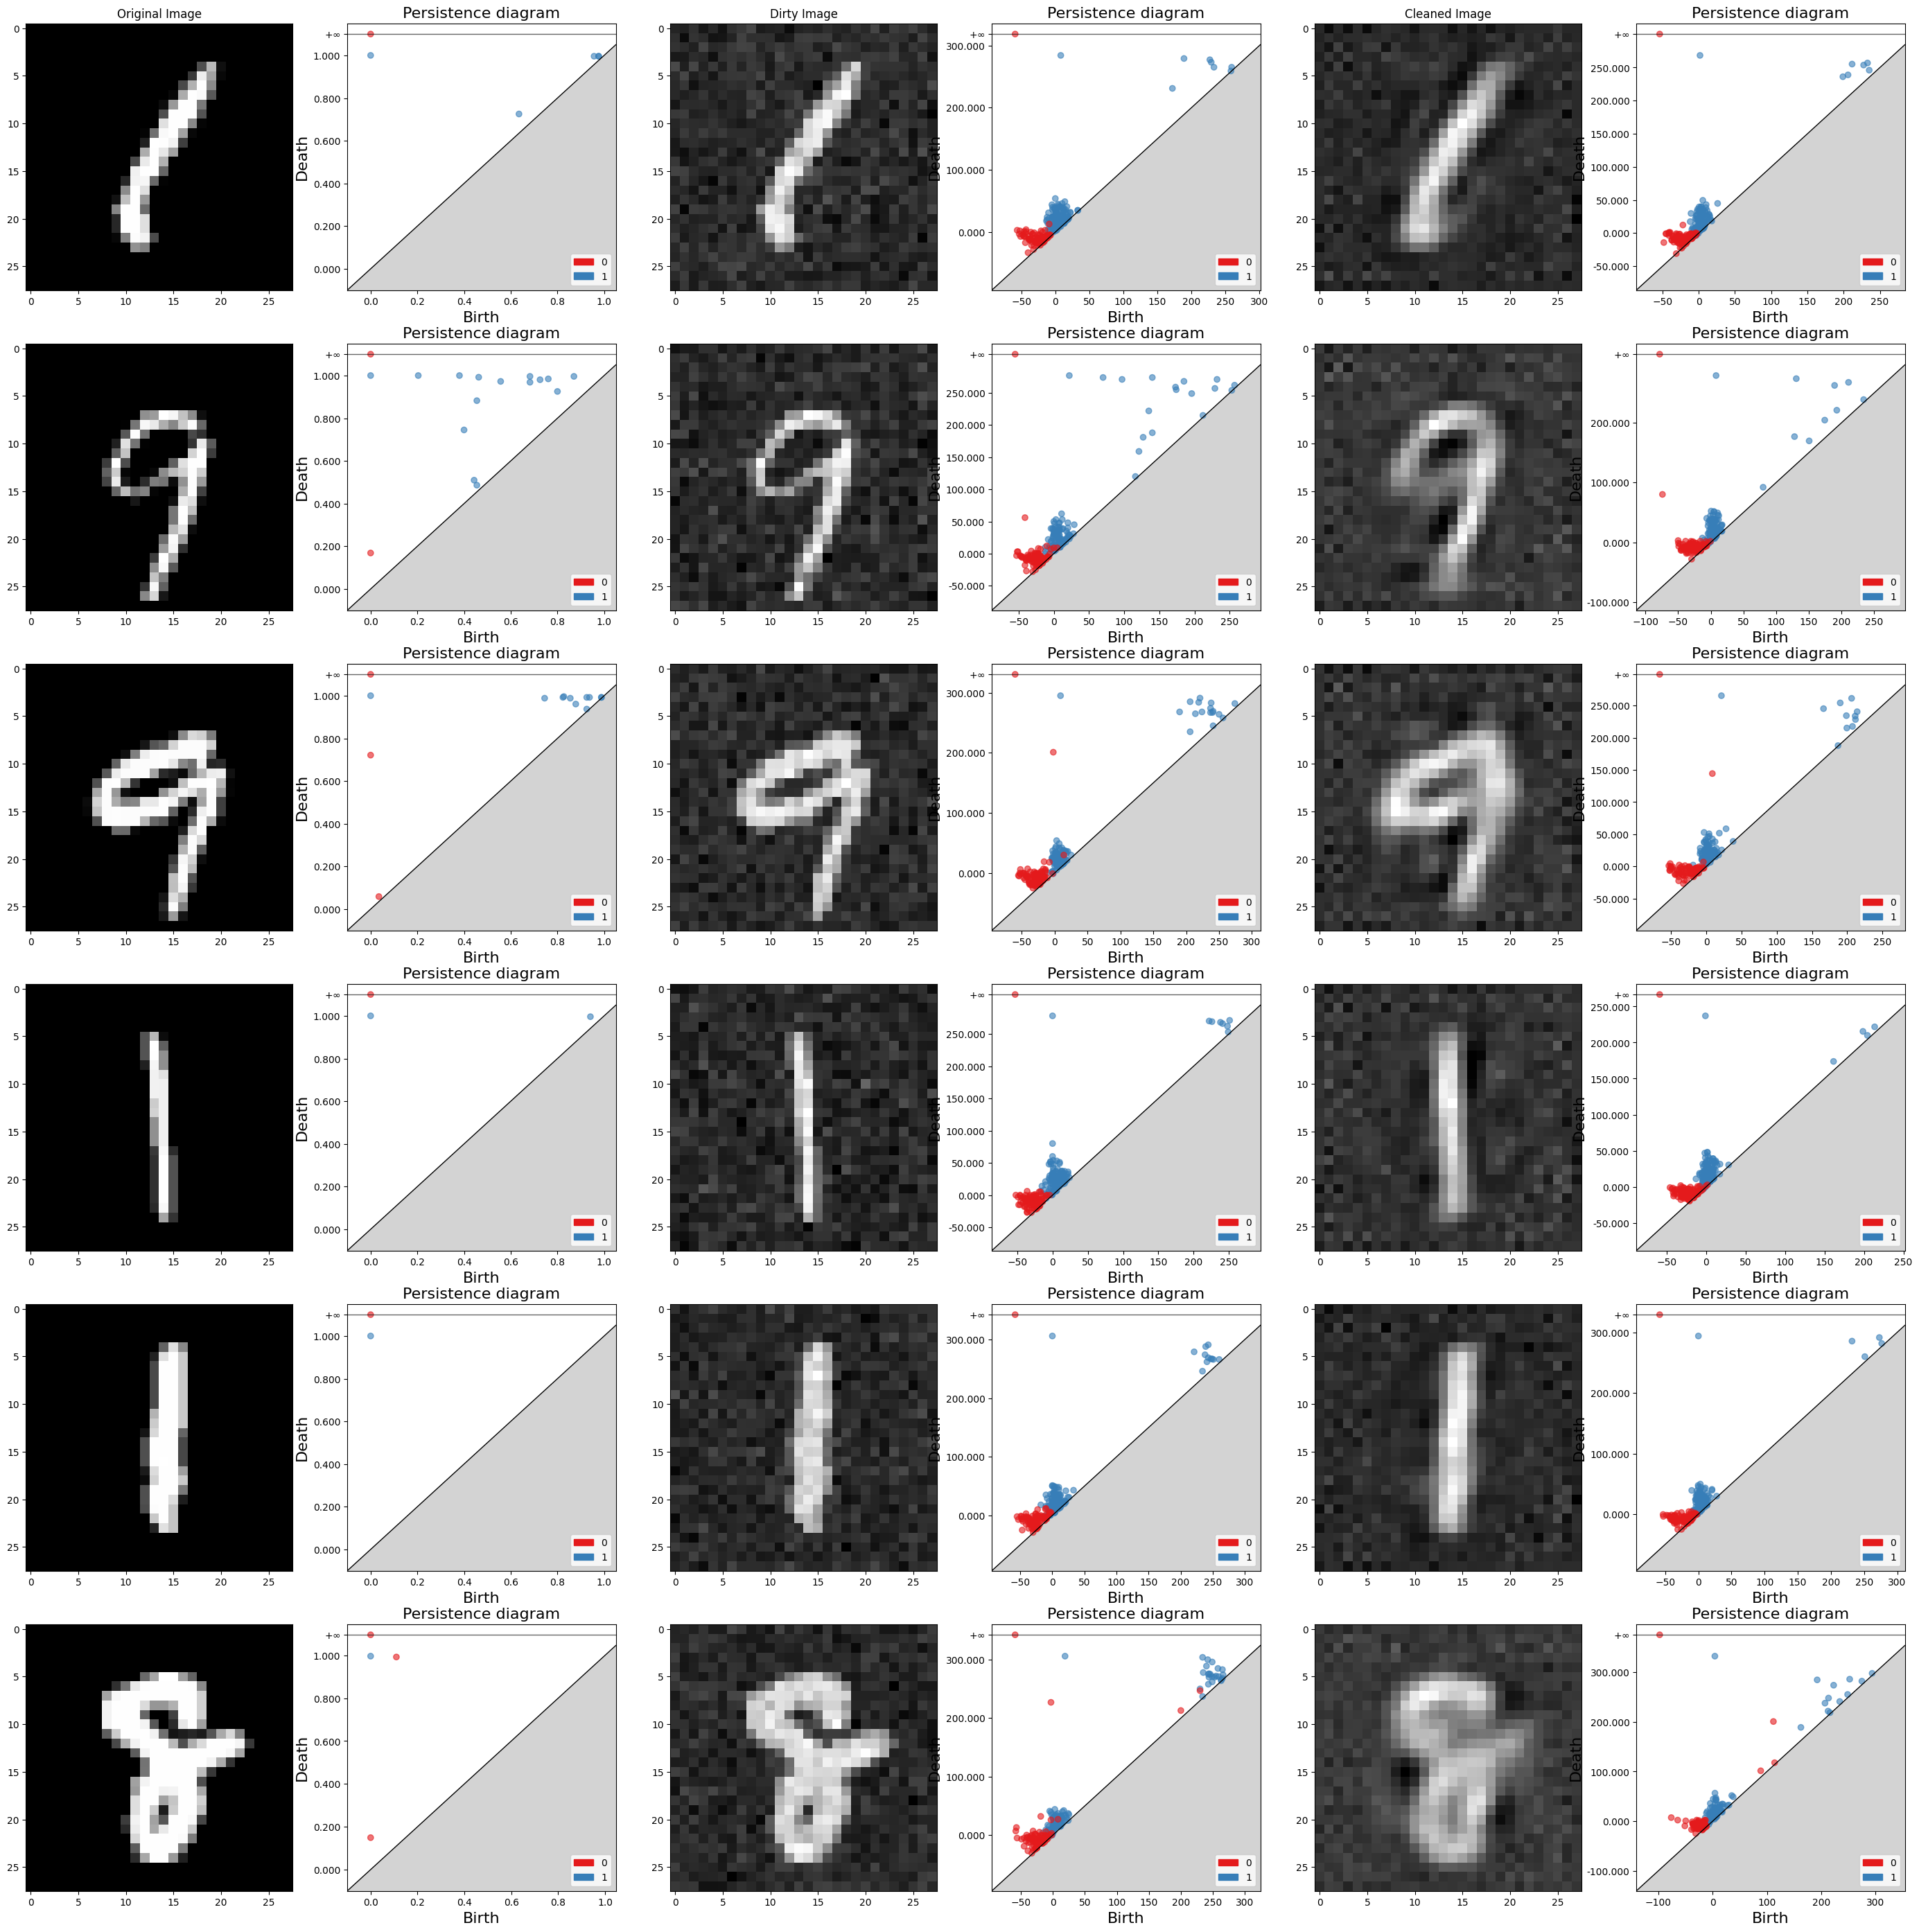

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[4138.83496094 1373.11450195]
  [2555.47460938 1170.81689453]
  [2165.87231445 1097.20568848]
  [1983.06494141 1059.66577148]
  [1875.54174805 1035.03100586]
  [1805.71594238 1016.6895752 ]
  [1761.40087891 1000.33081055]
  [1724.14489746  990.27435303]
  [1700.46691895  980.39727783]
  [1677.68273926  974.13751221]
  [1661.22766113  967.00506592]
  [1646.47009277  960.78424072]
  [1633.03222656  956.62799072]
  [1622.16577148  950.06750488]
  [1610.21118164  946.73394775]
  [1599.24267578  944.25390625]
  [1593.75134277  938.99682617]
  [1583.32080078  936.08221436]
  [1576.08959961  934.02526855]
  [1568.61291504  931.62457275]
  [1561.31738281  928.69488525]
  [1554.9239502   926.95483398]
  [1545.13378906  921.48126221]
  [1542.15820312  922.38684082]
  [1536.53845215  920.10272217]
  [1531.36022949  920.57702637]
  [1528.52490234  919.86114502]
  [1520.2532959   917.87542725]
  [1516.23254395  914.47772217]
  [1510.12792969  913.02270508]
  [1506.828125    911.84356689]
  [1501.